# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from scipy import io
import sys
tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

In [2]:
sys.path.append('Trained_models')

# Data loading

In [3]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [5]:
from tensorflow_datasets.core.splits import units
#test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input

# cnn_model.add(Flatten())
cnn_model.add(Input(shape=(28, 28,1)))
cnn_model.add( Conv2D( filters = 32, kernel_size = (3,3), strides = 1, activation = 'relu' ) )
cnn_model.add( MaxPooling2D( pool_size = (2,2), strides = 1 ) )
cnn_model.add( Conv2D( filters = 64, kernel_size = (3,3), strides = 1, activation = 'relu' ) )
cnn_model.add ( MaxPooling2D( pool_size = (2,2), strides = 2 ) )
cnn_model.add(Flatten())

cnn_model.add( Dropout( rate = 0.5 ) )
cnn_model.add ( Dense ( units = 128, activation = 'relu' ) )

cnn_model.add( Dropout( rate = 0.5 ) )
cnn_model.add ( Dense ( units = 10, activation = 'softmax' ) )
# your code start from here for stpe 2
cnn_model.save_weights('Trained_models/cnn_model_untrained.h5')



# your code start from here for step 2




In [ ]:
cnn_model.summary()

In [7]:
# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(Input(shape=(28, 28,1)))
fc_model.add(Flatten())

fc_model.add ( Dense ( units = 784, activation = 'relu' ) )
fc_model.add ( Dense ( units = 784, activation = 'relu' ) )
fc_model.add ( Dense ( units = 10, activation = 'softmax' ) )

fc_model.save_weights('Trained_models/fc_model_untrained.h5')
# cnn_model.summary()

In [8]:
fc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 784)               615440    
                                                                 
 dense_5 (Dense)             (None, 784)               615440    
                                                                 
 dense_6 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


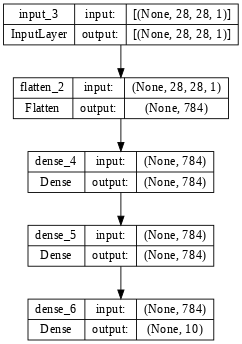

In [9]:
fc_model.build(input_shape=(28,28,1,))
tf.keras.utils.plot_model(fc_model, show_shapes=True, dpi=64)

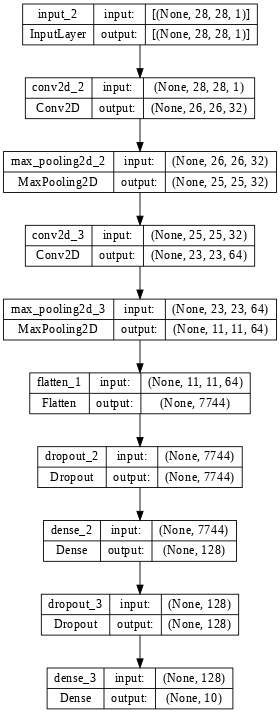

In [10]:
cnn_model.build(input_shape=(28,28,1,))
tf.keras.utils.plot_model(cnn_model, show_shapes=True, dpi=64)

# Teacher loss function

In [11]:
import numpy as np

In [12]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(subclass_logits,labels))
  return cross_entropy_loss_value

In [13]:
######### TEST #####################
n = 14
for i in mnist_test.take(1):
  test_sample = i
print(test_sample[0][:n,...].shape)
print(test_sample[1][:n,...].shape)
t1  = compute_teacher_loss(test_sample[0][:n,...],test_sample[1][:n,...])
print (t1)
# print(t2)

(14, 28, 28, 1)
(14, 10)
tf.Tensor(2.363753, shape=(), dtype=float32)


# Student loss function

In [14]:

# Hyperparameters for distillation (need to be tuned).
ALPHA =.5  # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4 #temperature hyperparameter
@tf.function
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  d = tf.math.exp(teacher_logits/temperature)
  n = tf.reduce_sum( tf.math.exp(teacher_logits/temperature))
  soft_targets =  d/n

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

@tf.function
def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(labels,student_subclass_logits))
  student_loss = cross_entropy_loss_value + ALPHA*10*distillation_loss_value
  return student_loss

# Train and evaluation

In [15]:
# @tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  KD = np.zeros(NUM_EPOCHS)
  CE = np.zeros(NUM_EPOCHS)
  acc =np.zeros(NUM_EPOCHS)
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images,labels in mnist_train:
      
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels)
        # trainable_vars = fc_model.trainable_variables
        
        #grads =
        grads = tape.gradient(loss_value, model.trainable_variables) 
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    #Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    acc[epoch-1] = num_correct / num_total * 100
    ##########################################################################################
    teacher_subclass_logits = cnn_model(images, training=False)
    class_logits = model(images, training=False)
    CE[epoch-1] = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(class_logits,labels))
    KD[epoch-1] = distillation_loss(teacher_subclass_logits,class_logits,DISTILLATION_TEMPERATURE)
    print("KD loss ",KD[epoch-1])
    ###########################################################################################
  return acc, KD, CE

# Training models

In [16]:
# your code start from here for step 5 
print('########### Training teacher model ##############')
cnn_model.load_weights('Trained_models/cnn_model_untrained.h5')
acc_teacher_2, _, CE_teacher_2 = train_and_evaluate(cnn_model,compute_teacher_loss)

########### Training teacher model ##############
Epoch 1: Class_accuracy: 96.77%
KD loss  2.2994227409362793
Epoch 2: Class_accuracy: 97.67%
KD loss  2.2993929386138916
Epoch 3: Class_accuracy: 98.30%
KD loss  2.2994585037231445
Epoch 4: Class_accuracy: 98.57%
KD loss  2.2994072437286377
Epoch 5: Class_accuracy: 98.58%
KD loss  2.299377918243408
Epoch 6: Class_accuracy: 98.61%
KD loss  2.299377918243408
Epoch 7: Class_accuracy: 98.72%
KD loss  2.299377918243408
Epoch 8: Class_accuracy: 98.94%
KD loss  2.299377918243408
Epoch 9: Class_accuracy: 98.75%
KD loss  2.299377918243408
Epoch 10: Class_accuracy: 98.86%
KD loss  2.299377918243408
Epoch 11: Class_accuracy: 98.83%
KD loss  2.299377918243408
Epoch 12: Class_accuracy: 98.79%
KD loss  2.2993788719177246


In [17]:
## Student training using CE + KD
print('########### Training student model using KD ##############')

ALPHA = .5
NUM_EPOCHS = 12
DISTILLATION_TEMPERATURE = 4
fc_model.load_weights('Trained_models/fc_model_untrained.h5')
acc_student_distil, KD_student_distil, CE_student_distil = train_and_evaluate(fc_model,compute_student_loss)

########### Training student model using KD ##############
Epoch 1: Class_accuracy: 96.98%
KD loss  2.2996091842651367
Epoch 2: Class_accuracy: 98.00%
KD loss  2.2995903491973877
Epoch 3: Class_accuracy: 98.23%
KD loss  2.299506664276123
Epoch 4: Class_accuracy: 98.59%
KD loss  2.299508571624756
Epoch 5: Class_accuracy: 98.45%
KD loss  2.2995102405548096
Epoch 6: Class_accuracy: 98.45%
KD loss  2.2995657920837402
Epoch 7: Class_accuracy: 98.68%
KD loss  2.2995243072509766
Epoch 8: Class_accuracy: 98.72%
KD loss  2.2995071411132812
Epoch 9: Class_accuracy: 98.69%
KD loss  2.2995190620422363
Epoch 10: Class_accuracy: 98.73%
KD loss  2.2994978427886963
Epoch 11: Class_accuracy: 98.73%
KD loss  2.299511194229126
Epoch 12: Class_accuracy: 98.68%
KD loss  2.299516201019287


# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
Temp_list = [1, 2, 4, 8, 16, 32, 64]
ALPHA = 1
cnt = 0
Num_sim = 1
T = np.zeros(len(Temp_list))
acc_list = []
KD_list = []
CE_list = []
for i in range(Num_sim):
  print('Simulation number ',i)
  for temp in Temp_list:
    fc_model.load_weights('Trained_models/fc_model_untrained.h5')
    DISTILLATION_TEMPERATURE = temp 
    print('############# Training student model with Tempreture = '+ str(temp)+ ' ###########')
    a, b, c = train_and_evaluate(fc_model,compute_student_loss)
    acc_list.append(a)
    KD_list.append(b)
    CE_list.append(c)


    #######################
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(fc_model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    T[cnt] = num_correct / num_total * 100
    cnt +=1
  
  #######################
  # avg_results = np.mean(T,axis =1)

In [ ]:
acc_end = []
for i in range(7):
  acc_end.append(acc_list[i][-1])
plt.plot(Temp_list,acc_end,linestyle='solid',linewidth=2, markersize=12,marker='*')  
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Test Accuracy (%)')
plt.grid()

# Train student from scratch

In [ ]:
# Build fully connected student. 
fc_model_no_distillation = tf.keras.Sequential()
fc_model_no_distillation.add(Input(shape=(28, 28,1)))
fc_model_no_distillation.add(Flatten())

fc_model_no_distillation.add ( Dense ( units = 784, activation = 'relu' ) )
fc_model_no_distillation.add ( Dense ( units = 784, activation = 'relu' ) )
fc_model_no_distillation.add ( Dense ( units = 10, activation = 'softmax' ) )
fc_model_no_distillation.load_weights('Trained_models/fc_model_untrained.h5')
# cnn_model.summary()
# your code start from here for step 7


def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(labels,student_subclass_logits))
  
  return cross_entropy_loss

acc_student_scratch, KD_student_scratch, CE_student_scratch = train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 95.49%
KD loss  9.207513809204102
Epoch 2: Class_accuracy: 96.40%
KD loss  9.207343101501465
Epoch 3: Class_accuracy: 96.79%
KD loss  9.207343101501465
Epoch 4: Class_accuracy: 96.88%
KD loss  9.207343101501465
Epoch 5: Class_accuracy: 97.31%
KD loss  9.207624435424805
Epoch 6: Class_accuracy: 97.38%
KD loss  9.207343101501465
Epoch 7: Class_accuracy: 97.57%
KD loss  9.207343101501465
Epoch 8: Class_accuracy: 97.41%
KD loss  9.207343101501465
Epoch 9: Class_accuracy: 97.79%
KD loss  9.207504272460938
Epoch 10: Class_accuracy: 97.77%
KD loss  9.207343101501465
Epoch 11: Class_accuracy: 97.82%
KD loss  9.207343101501465
Epoch 12: Class_accuracy: 97.85%
KD loss  9.207344055175781


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:

# your code start from here for step 8
!pip install model_profiler
from model_profiler import model_profiler
# keep order 
units = ['GPU IDs', 'MFLOPs', 'GB', 'Million', 'MB']

Batch_size = 32
profile1 = model_profiler(cnn_model, Batch_size,use_units=units,)
profile2= model_profiler(fc_model, Batch_size,use_units=units,)
print("teacher")
print(profile1)
print("student")
print(profile2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.2188  | MFLOPs  |
| GPU Memory Requirement           | 0.0127  | GB      |
| Model Parameters                 | 1.0115  | Million |
| Memory Required by Model Weights | 3.8584  | MB      |
| Model Profile                    | Value   | Unit    |
|----------------------------------|---------|---------|
| Selected GPUs                    | ['0']   | GPU IDs |
| No. of FLOPs                     | 0.0248  | MFLOPs  |
| GPU Memory Requirement           | 0.0014  | GB      |
| Model Parameters                 | 1.2387  | Million |
| Memory Required by Model Weights | 4.7254  | MB      |


/usr/local/lib/python3.7/dist-packages/model_profiler/profiler.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(values).reshape(-1,1),


# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 5 
print('########### Training teacher model with early stop##############')
NUM_EPOCHS = 6 ## early stopping the teacher's training
cnn_model.load_weights('Trained_models/cnn_model_untrained.h5')
acc_teacher_2, _, CE_teacher_2 = train_and_evaluate(cnn_model,compute_teacher_loss)


def train_and_evaluate_SOTA_Alg(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
  acc = np.zeros((NUM_EPOCHS))
  for epoch in range(1, NUM_EPOCHS + 1):

    ## Check if the epoch No. is reached to the half of the total iteration No.
    # if epoch >=5:
    #   ALPHA = 0 ## Hard-tuning; releasing the student to learn by its own after a while
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images,labels in mnist_train:
      
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels)
        # trainable_vars = fc_model.trainable_variables
        
        #grads =
        grads = tape.gradient(loss_value, model.trainable_variables) 
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    #Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    acc[epoch-1] = num_correct / num_total * 100
  return acc

In [ ]:
# your code start from here for step 6
NUM_EPOCHS = 12
Temp_list = [ 4,]
ALPHA = 12
cnt = 0
acc_list_SOTA = []
T = np.zeros(len(Temp_list))
for temp in Temp_list:
  fc_model.load_weights('/content/fc_model_untrained.h5')
  DISTILLATION_TEMPERATURE = temp 
  print('############# Training student model with Tempreture = '+ str(temp)+ ' ###########')
  a = train_and_evaluate_SOTA_Alg(fc_model,compute_student_loss)
  acc_list_SOTA.append(a)
  #######################
  num_correct = 0
  num_total = builder.info.splits['test'].num_examples
  for images, labels in mnist_test:
    # your code start from here for step 4
    num_correct += compute_num_correct(fc_model,images,labels)[0]
  print("Class_accuracy: " + '{:.2f}%'.format(
      num_correct / num_total * 100))
  T[cnt] = num_correct / num_total * 100
  cnt +=1
  #######################

############# Training student model with Tempreture = 16 ###########
Epoch 1: Class_accuracy: 97.39%
Epoch 2: Class_accuracy: 98.23%
Epoch 3: Class_accuracy: 98.53%
Epoch 4: Class_accuracy: 98.74%
Epoch 5: Class_accuracy: 98.65%
Epoch 6: Class_accuracy: 98.66%
Epoch 7: Class_accuracy: 98.69%
Epoch 8: Class_accuracy: 98.76%
Epoch 9: Class_accuracy: 98.79%
Epoch 10: Class_accuracy: 98.78%
Epoch 11: Class_accuracy: 98.78%
Epoch 12: Class_accuracy: 98.70%
Class_accuracy: 98.70%


# (Optional) XAI method to explain models

In [ ]:
# your code start from here for step 13


#plotting the results

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(acc_teacher[:12],linestyle='solid',linewidth=4, markersize=12)
plt.plot(CE_student_scratch, linestyle='-',linewidth=4, markersize=12)
plt.plot(acc_student_distil, linestyle='dotted',linewidth=4, markersize=12)
plt.plot(acc_list_SOTA[0], linestyle='dashed',linewidth=4, markersize=12)

plt.legend(['Teacher model', 'Student model', 'Student model early stop'])
plt.xlabel('Epoch (No.)')
plt.ylabel('Test Accuracy(%)')
plt.grid()
plt.savefig('/content/Task_2_ALPHA=12_TEMP=8',dip=200)

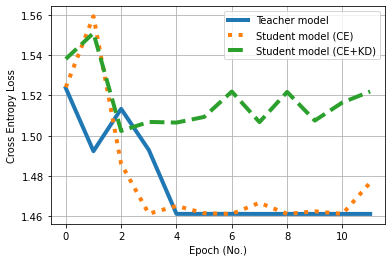

In [ ]:
plt.plot(CE_teacher,linestyle='solid',linewidth=4, markersize=12)
plt.plot(CE_student_scratch, linestyle='dotted',linewidth=4, markersize=12)
plt.plot(CE_student_distil, linestyle='dashed',linewidth=4, markersize=12)
plt.legend(['Teacher model', 'Student model (CE)', 'Student model (CE+KD)'])
plt.xlabel('Epoch (No.)')
plt.ylabel('Cross Entropy Loss')
plt.grid()


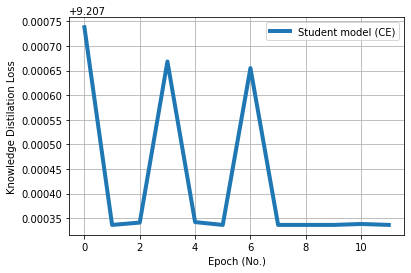

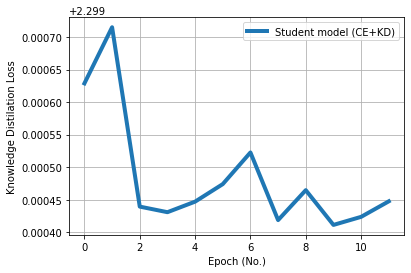

In [ ]:
# plt.plot(KD_teacher,linestyle='solid',linewidth=4, markersize=12)
plt.plot(KD_student_scratch, linestyle='solid',linewidth=4, markersize=12)
# plt.plot(KD_student_distil, linestyle='dashed',linewidth=4, markersize=12)
plt.legend([ 'Student model (CE)'])
plt.xlabel('Epoch (No.)')
plt.ylabel('Knowledge Distilation Loss')
plt.grid()

plt.figure()
plt.plot(KD_student_distil, linestyle='solid',linewidth=4, markersize=12)
plt.legend([ 'Student model (CE+KD)'])
plt.xlabel('Epoch (No.)')
plt.ylabel('Knowledge Distilation Loss')
plt.grid()


In [ ]:
acc_end = []
for i in range(7):
  acc_end.append(acc_list[i][-1])

plt.plot(CE_teacher,linestyle='solid',linewidth=4, markersize=12)
plt.plot(CE_student_scratch, linestyle='dotted',linewidth=4, markersize=12)
plt.plot(CE_student_distil, linestyle='dashed',linewidth=4, markersize=12)
plt.legend(['Teacher model', 'Student model (CE)', 'Student model (CE+KD)'])
plt.xlabel('Epoch (No.)')
plt.ylabel('Cross Entropy Loss')
plt.grid()


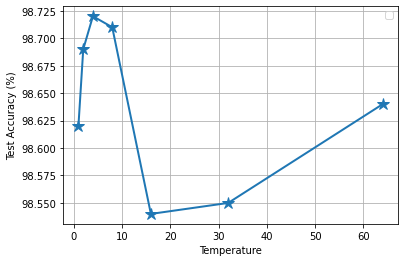

In [ ]:
acc_end = []
for i in range(7):
  acc_end.append(acc_list[i][-1])
acc_end[6] = 98.64
plt.plot(Temp_list,acc_end,linestyle='solid',linewidth=2, markersize=12,marker='*')  
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Test Accuracy (%)')
plt.grid()
